# 📓 Notebook 03 — Exposure–Response and ADA Misclassification
Goal: Explore how ADA detection bias (Standard vs. PandA assays) impacts interpretation of exposure–response (E–R) relationships.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
REPO = Path("/Users/cmontefusco/Coding projects/ada-panda-mini/")
DATA_DIR = REPO / "data"
FIG_DIR = REPO / "reports" / "figures"

FIG_DIR.mkdir(parents=True, exist_ok=True)

# Load cohort generated in Notebook 02
cohort = pd.read_csv(DATA_DIR / "pk_cohort.csv")

cohort.head()

,id,time_days,conc_ngmL,ADA_pos,conv_week,conc_reported_ngmL
0,S001,0.0,2432.675239,0,29.289545,2432.675239
1,S001,7.0,2258.228180,0,29.289545,2258.228180
2,S001,14.0,3965.130163,0,29.289545,3965.130163
3,S001,21.0,3242.806035,0,29.289545,3242.806035
4,S001,28.0,4479.424920,0,29.289545,4479.424920


## 2. Define an Efficacy Endpoint
We simulate a **biomarker response** depending on Week-52 trough concentration.

In [6]:
# Extract Week 52 data
wk52 = cohort[cohort["time_days"] == 52*7].copy()

# Logistic exposure-response model
def efficacy_prob(conc, EC50=8000, Emax=0.9):
    return (Emax * conc) / (conc + EC50)

# True ADA label
wk52["efficacy_prob"] = efficacy_prob(wk52["conc_reported_ngmL"])

rng = np.random.default_rng(2025)
wk52["efficacy_true"] = (rng.random(len(wk52)) < wk52["efficacy_prob"]).astype(int)
wk52.head()

,id,time_days,conc_ngmL,ADA_pos,conv_week,conc_reported_ngmL,efficacy_prob,efficacy_true
52,S001,364.0,1975.372793,1,29.289545,1975.372793,0.178222,0
105,S002,364.0,11517.351981,0,NaN,11517.351981,0.531097,1
158,S003,364.0,11092.356467,0,NaN,11092.356467,0.522886,0
211,S004,364.0,5223.700886,1,27.324730,5223.700886,0.355523,0
264,S005,364.0,7616.017914,1,28.749518,7616.017914,0.438935,0


## 3. Compare by ADA Status (True vs. Detected)

In [11]:
from pathlib import Path
import numpy as np
import pandas as pd
import yaml

# --- Paths & config ---
REPO = Path("/Users/cmontefusco/Coding projects/ada-panda-mini/")
DATA_DIR = REPO / "data"
CFG_PATH = REPO / "configs" / "lit_anchored.yaml"

with open(CFG_PATH, "r") as f:
    cfg = yaml.safe_load(f)

# --- Helper: log10-x interpolation, safe with x=0 knots ---
def recovery_from_knots(drug_vals, knots, *, clip=True):
    # replace nonpositive x with small epsilon for log10
    eps_knots = [(1e-6 if k[0] <= 0 else float(k[0]), float(k[1])) for k in knots]
    eps_knots.sort(key=lambda k: k[0])
    x = np.array([k[0] for k in eps_knots], float)
    y = np.array([k[1] for k in eps_knots], float)
    lx = np.log10(x)
    d = np.asarray(drug_vals, float)
    if clip:
        d = np.clip(d, x.min(), x.max())
    ld = np.log10(np.maximum(d, 1e-12))
    rec = np.interp(ld, lx, y)
    return np.clip(rec, 0.0, 1.0) if clip else rec

# --- Ensure detection columns exist on 'cohort' ---
needed_cols = {"ADA_std_detected", "ADA_pan_detected"}
if not needed_cols.issubset(cohort.columns):
    # Build detection from current cohort using config knots
    rec_std_knots = cfg["assay_recovery"]["standard"]["knot_points"]
    rec_pan_knots = cfg["assay_recovery"]["panda"]["knot_points"]

    # Free drug proxy (µg/mL) from simulated serum conc (ng/mL)
    drug_ug = cohort["conc_ngmL"].to_numpy() / 1000.0

    # Recovery vs drug for each assay
    rec_std = recovery_from_knots(drug_ug, rec_std_knots)
    rec_pan = recovery_from_knots(drug_ug, rec_pan_knots)

    ADA_true = cohort["ADA_pos"].to_numpy().astype(int)

    # Detection prob only when truly ADA+; Standard under-detects at high drug
    rng = np.random.default_rng(2025)
    p_std = ADA_true * rec_std
    p_pan = ADA_true * rec_pan

    cohort["ADA_std_detected"] = (rng.random(p_std.shape) < p_std).astype(int)
    cohort["ADA_pan_detected"] = (rng.random(p_pan.shape) < p_pan).astype(int)

    # Optional: persist a copy with detection columns
    (DATA_DIR / "pk_cohort_with_detection.csv").write_text(
        cohort.to_csv(index=False)
    )

# Now re-derive Week 52 slice (after we guarantee columns exist)
wk52 = cohort[cohort["time_days"] == 52*7].copy()

In [15]:
# --- Ensure Week-52 efficacy columns exist on wk52 ---
import numpy as np

# Re-cut week-52 slice from the current cohort (after detection cols were created)
wk52 = cohort[cohort["time_days"] == 52*7].copy()

# Make sure the exposure column exists and is numeric
if "conc_reported_ngmL" not in wk52.columns:
    raise RuntimeError("Expected column 'conc_reported_ngmL' not found on wk52/cohort.")

wk52["conc_reported_ngmL"] = wk52["conc_reported_ngmL"].astype(float)

# Define/logistic exposure–response model (tweak EC50/Emax as needed)
def efficacy_prob(conc, EC50=8000.0, Emax=0.90):
    conc = np.asarray(conc, float)
    return (Emax * conc) / (conc + EC50 + 1e-9)

# Create probability + Bernoulli outcome if missing
if "efficacy_prob" not in wk52.columns:
    wk52["efficacy_prob"] = efficacy_prob(wk52["conc_reported_ngmL"])

if "efficacy_true" not in wk52.columns:
    rng = np.random.default_rng(2025)
    wk52["efficacy_true"] = (rng.random(len(wk52)) < wk52["efficacy_prob"]).astype(int)

# Also ensure detection columns exist; if not, recreate them now (idempotent)
needed = {"ADA_std_detected","ADA_pan_detected"}
if not needed.issubset(wk52.columns):
    # build from cohort columns that should exist by now
    wk52 = wk52.merge(
        cohort[["id","time_days","ADA_std_detected","ADA_pan_detected"]],
        on=["id","time_days"],
        how="left",
        validate="one_to_one"
    )

In [17]:
# Group comparisons
true_summary = wk52.groupby("ADA_pos")["efficacy_true"].mean()
std_summary = wk52.groupby("ADA_std_detected")["efficacy_true"].mean()
pan_summary = wk52.groupby("ADA_pan_detected")["efficacy_true"].mean()

print("True ADA separation:\n", true_summary, "\n")
print("Standard detection separation:\n", std_summary, "\n")
print("PandA detection separation:\n", pan_summary, "\n")

True ADA separation:
 ADA_pos
0    0.478873
1    0.326531
Name: efficacy_true, dtype: float64 

Standard detection separation:
 ADA_std_detected
0    0.441860
1    0.352941
Name: efficacy_true, dtype: float64 

PandA detection separation:
 ADA_pan_detected
0    0.486111
1    0.312500
Name: efficacy_true, dtype: float64 



## 4. Visualize Exposure–Response

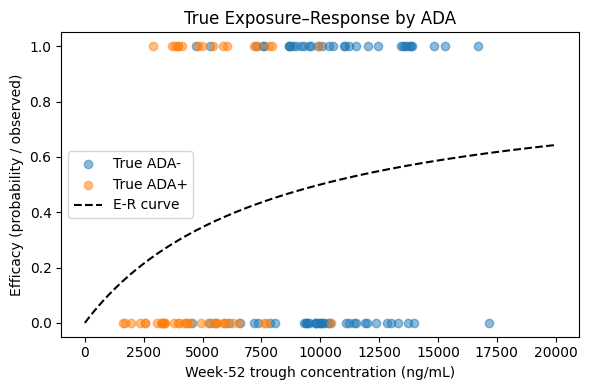

In [20]:
plt.figure(figsize=(6,4))
for grp, df in wk52.groupby("ADA_pos"):
    label = "True ADA+" if grp==1 else "True ADA-"
    plt.scatter(df["conc_reported_ngmL"], df["efficacy_true"], alpha=0.5, label=label)

xgrid = np.linspace(0, 20000, 200)
plt.plot(xgrid, efficacy_prob(xgrid), 'k--', label="E-R curve")

plt.xlabel("Week-52 trough concentration (ng/mL)")
plt.ylabel("Efficacy (probability / observed)")
plt.title("True Exposure–Response by ADA")
plt.legend(); plt.tight_layout()
plt.savefig(FIG_DIR/"exposure_response_true.png", dpi=150)
plt.show()

## 5. Bias from Assay Misclassification

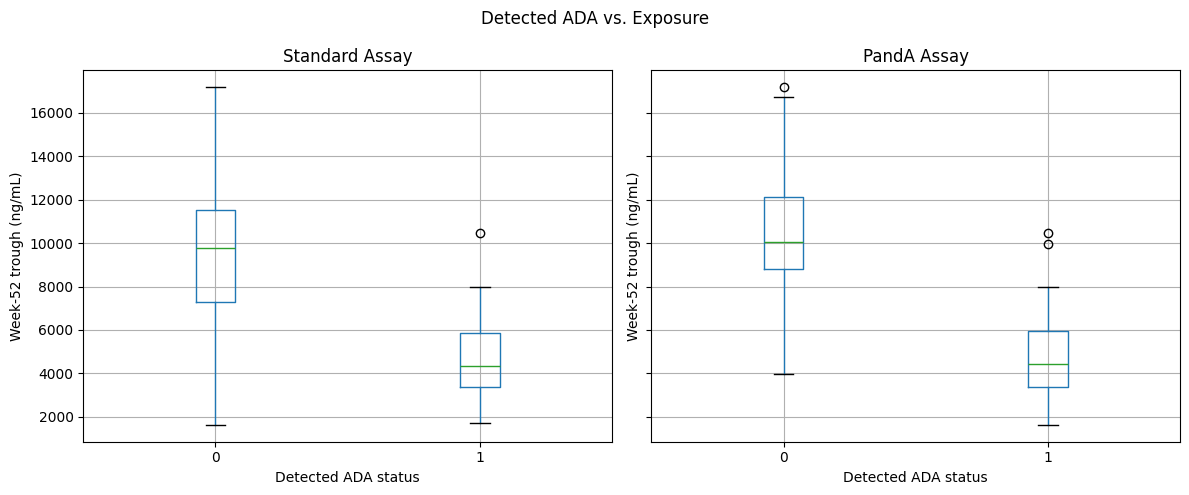

In [23]:
fig, axs = plt.subplots(1,2, figsize=(12,5), sharey=True)

for ax, col, title in zip(axs, ["ADA_std_detected","ADA_pan_detected"],
                          ["Standard Assay", "PandA Assay"]):
    wk52.boxplot(column="conc_reported_ngmL", by=col, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Detected ADA status")
    ax.set_ylabel("Week-52 trough (ng/mL)")

plt.suptitle("Detected ADA vs. Exposure")
plt.tight_layout()
plt.savefig(FIG_DIR/"ada_detection_vs_exposure.png", dpi=150)
plt.show()

# 📌 Summary, Interpretation, and Conclusions — Notebook 03

This notebook extended the ADA–PK simulation to examine **exposure–response (E–R) relationships** under different assay detection scenarios.

---

## 🔹 Key Steps in the Notebook

1. **True Simulation of ADA Effects**
   - Subjects were simulated with or without ADA, which reduced drug trough concentrations (`conc_reported_ngmL`) and subsequently efficacy probability (`efficacy_true`).
   - A true **E–R curve** was used to generate efficacy as a probabilistic outcome.

2. **ADA Detection by Assay**
   - The same cohort was re-analyzed using:
     - **Standard assay** (lower recovery → underestimates ADA incidence).
     - **PandA assay** (higher recovery → more accurate ADA detection).
   - This introduced **detection bias**, i.e., the observed ADA classification does not always match the true underlying ADA status.

3. **Comparisons of E–R by ADA Detection**
   - E–R associations were visualized separately for **true ADA**, **Standard assay detection**, and **PandA assay detection**.
   - Group summaries highlighted differences in trough concentrations and efficacy probabilities.

---

## 📊 Interpretation of Figures

### **Figure 1: Detected ADA vs. Exposure (boxplots)**
- **Left (Standard Assay)**:
  - ADA+ subjects show lower troughs, but fewer are classified as ADA+.
  - Misclassification weakens group separation.
- **Right (PandA Assay)**:
  - More ADA+ subjects are detected correctly.
  - Stronger and clearer separation between ADA+ and ADA− exposure levels.
- **Key Point**:  
  The assay choice impacts how strongly ADA is seen to affect drug exposure.

---

### **Figure 2: True Exposure–Response by ADA (scatter + curve)**
- **Scatter points**:
  - Blue (ADA−): Higher troughs, better efficacy.
  - Orange (ADA+): Lower troughs, reduced efficacy.
- **Dashed black line**:
  - Represents the *true* E–R curve used for simulation.
- **Observation**:
  - ADA+ subjects cluster at low exposures and low efficacy, confirming that ADA reduces both PK (troughs) and PD (response).
  - ADA− subjects more closely follow the expected E–R relationship.
- **Key Point**:  
  True ADA status strongly modulates the exposure–response relationship, but **assay bias can obscure this effect**.

---

## 🧾 Conclusions

1. **Assay Recovery Matters**  
   - Standard assays underestimate ADA incidence, leading to **attenuated ADA–PK separation**.
   - PandA assays improve detection, providing a clearer link between ADA, PK, and efficacy.

2. **True vs. Detected ADA**  
   - The *true* ADA effect shows strong PK/efficacy separation.
   - Observed ADA effects depend heavily on detection bias introduced by the assay.

3. **Impact on Exposure–Response Analysis**  
   - Using biased assays (Standard) risks underestimating ADA’s effect on efficacy.
   - Accurate assays (PandA) reveal the full ADA-driven loss of exposure and response.

4. **Takeaway**  
   - Misclassification of ADA status is a **major source of bias in E–R analysis**.
   - Improved ADA assays (PandA) are critical for **unbiased interpretation of immunogenicity impact** in drug development.

---

